In [1]:
import os
import sys 
sys.path.insert(0, '/home/aiwenxu/2022-xu-retinal-degeneration')

**Part 1: healthy threshold**

In [ ]:
import numpy as np
from model.retinasim_phase12.simulation import estim_to_retina_output
from model.retinasim_phase12.simulation_utils import SimulationParam
import pickle
from brian2 import *
import pulse2percept as p2p

In [ ]:
def calculate_mean_std_center(spikes_gl, cell_type):
    num_spikes = []
    x, y = np.load("../model/layout_phase12/dendritic-tree-coordinate-100/GL_{}.npy".format(cell_type.upper()))
    for key in spikes_gl['t']:
        if np.sqrt(np.square(x[key]) + np.square(y[key])) <= 40:
            num_spikes.append(len(spikes_gl['t'][key]))
    spike_ar = np.array(num_spikes)
    return np.mean(num_spikes), np.std(num_spikes)

In [ ]:
result_mean_on = []
result_mean_off = []
result_std_on = []
result_std_off = []
pre_computed_weights_folder = "../model/weights_phase12"
implant_mode = "epiretinal"
light_g_max = 0.9
cone_population = 100
sp_txt = "../model/parameter/cottaris_original_2hz.txt"
sp = SimulationParam(sp_txt)
sp.xy_coord_folder = "../model/layout_phase12/dendritic-tree-coordinate-{}".format(cone_population)
sp.z_coord_folder = "../model/layout_phase12/z-coordinate-{}".format(cone_population)
sp.imped = 1000
# subretinal stimulation
if implant_mode == "subretinal":
    sp.implant_mode = "subretinal"
    sp.electrode_z = 135
    
for amp in np.arange(20, 35, 5):

    pt = p2p.stimuli.BiphasicPulseTrain(20, amp, 0.45, stim_dur=1000, cathodic_first=True)

    time_in_ms = 1000
    select_GPU = 1
    genn_directory = "GeNNworkspace_{}".format(select_GPU)
    _, _, _, _, _, _, _, _, _, spikes_gl_on, spikes_gl_off = estim_to_retina_output(time_in_ms, sp, light_g_max, pt, pre_computed_weights_folder, delta_ve_folder="delta_ve_workspace_{}".format(select_GPU), dt=0.1, select_GPU=select_GPU, genn_directory=genn_directory)

    mean_on, std_on = calculate_mean_std_center(spikes_gl_on, "on")
    mean_off, std_off = calculate_mean_std_center(spikes_gl_off, "off")
    
    print("amp: {}, mean on spikes: {}, mean off spikes: {}".format(amp, mean_on, mean_off))
    result_mean_on.append(mean_on)
    result_mean_off.append(mean_off)
    result_std_on.append(std_on)
    result_std_off.append(std_off)

* ON RGCs: 30 uA
* OFF RGCs: 30 uA

**Part 2: degeneration threshold**

In [ ]:
for light_g_max, cone_population in [(0.75, 80), (0.6, 60), (0.45, 40), (0.3, 20)]:

    implant_mode = "epiretinal"
    healthy_threshold = 30
    
    pre_computed_weights_folder = "../model/weights_phase12"

    sp_txt = "../model/parameter/cottaris_original_2hz.txt"
    sp = SimulationParam(sp_txt)

    sp.xy_coord_folder = "../model/layout_phase12/dendritic-tree-coordinate-{}".format(cone_population)
    sp.z_coord_folder = "../model/layout_phase12/z-coordinate-{}".format(cone_population)
    sp.imped = 1000

    # subretinal stimulation
    if implant_mode == "subretinal":
        sp.implant_mode = "subretinal"
        sp.electrode_z = 135

    for percentage in range(0, 305, 5):

        amp = healthy_threshold * percentage / 100

        pt = p2p.stimuli.BiphasicPulseTrain(20, amp, 0.45, stim_dur=1000, cathodic_first=True)

        time_in_ms = 1000
        select_GPU = 1
        genn_directory = "GeNNworkspace_{}".format(select_GPU)
        _, _, _, _, _, _, _, _, _, spikes_gl_on, spikes_gl_off = estim_to_retina_output(time_in_ms, sp, light_g_max, pt, pre_computed_weights_folder, delta_ve_folder="delta_ve_workspace_{}".format(select_GPU), dt=0.1, select_GPU=select_GPU, genn_directory=genn_directory)

        data_folder = "../data/fig11/data-threshold-{}-{}-{}/data-{}".format(implant_mode, light_g_max, cone_population, percentage)
        if not os.path.exists(data_folder):
            os.makedirs(data_folder)

        with open('{}/spikes_gl_on.pickle'.format(data_folder), 'wb') as f:
            pickle.dump(spikes_gl_on, f)

        with open('{}/spikes_gl_off.pickle'.format(data_folder), 'wb') as f:
            pickle.dump(spikes_gl_off, f)

In [ ]:
from model.retinasim_phase3.simulation import estim_to_retina_output
from model.retinasim_phase3.simulation_utils import SimulationParam

pre_computed_weights_folder = "../model/weights_phase3"
implant_mode = "epiretinal"
healthy_threshold = 30

cell_percents = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10]
move_percents = [0, 10, 10, 20, 20, 30, 30, 40, 40, 50]

for i in range(10):
    
    cell_percent = cell_percents[i]
    move_percent = move_percents[i]
        
    sp_txt = "../model/parameter/cottaris_original_2hz.txt"
    sp = SimulationParam(sp_txt)

    sp.xy_coord_folder = "../model/layout_phase3/dendritic-tree-coordinate-{}".format(cell_percent)
    if move_percent == 0:
        sp.z_coord_folder = "../model/layout_phase3/z-coordinate-{}".format(cell_percent)
    else:
        sp.z_coord_folder = "../model/layout_phase3/z-coordinate-{}-move-{}".format(cell_percent, move_percent)
    sp.cone_exists = False
    sp.imped = 1000
    
    # implant mode
    if implant_mode == "subretinal":
        sp.implant_mode = "subretinal"
        sp.electrode_z = 135
        
    for percentage in range(0, 805, 5):
        
        amp = healthy_threshold * percentage / 100

        pt = p2p.stimuli.BiphasicPulseTrain(20, amp, 0.45, stim_dur=1000, cathodic_first=True)

        time_in_ms = 1000
        select_GPU = 0
        genn_directory = "GeNNworkspace_{}".format(select_GPU)
        _, _, _, _, _, _, _, _, _, spikes_gl_on, spikes_gl_off = estim_to_retina_output(time_in_ms, sp, pt, pre_computed_weights_folder, dt=0.1, delta_ve_folder="delta_ve_workspace_{}".format(select_GPU), select_GPU=select_GPU, genn_directory=genn_directory)

        data_folder = "../data/fig11/data-threshold-{}-{}-{}/data-{}".format(implant_mode, cell_percent, move_percent, percentage)
        if not os.path.exists(data_folder):
            os.makedirs(data_folder)

        with open('{}/spikes_gl_on.pickle'.format(data_folder), 'wb') as f:
            pickle.dump(spikes_gl_on, f)

        with open('{}/spikes_gl_off.pickle'.format(data_folder), 'wb') as f:
            pickle.dump(spikes_gl_off, f)

In [ ]:
from model.retinasim_phase3.simulation_rgc_only import estim_to_retina_output
from model.retinasim_phase3.simulation_utils import SimulationParam

implant_mode = "epiretinal"
healthy_threshold = 30
        
sp_txt = "../model/parameter/cottaris_original_2hz.txt"
sp = SimulationParam(sp_txt)

# This run simulates 0% cell (100% cell death), but here cell_percent=10 is used.
# This doesn't matter because the delta_ve values for the nonexistent cells will
# not be used.
cell_percent = 0
move_percent = 50
sp.xy_coord_folder = "../model/layout_phase3/dendritic-tree-coordinate-{}".format(10)
sp.z_coord_folder = "../model/layout_phase3/z-coordinate-{}-move-50".format(10, move_percent)
sp.cone_exists = False
sp.imped = 1000

# implant mode
if implant_mode == "subretinal":
    sp.implant_mode = "subretinal"
    sp.electrode_z = 135

for percentage in range(100, 805, 5):
        
    amp = healthy_threshold * percentage / 100

    pt = p2p.stimuli.BiphasicPulseTrain(20, amp, 0.45, stim_dur=1000, cathodic_first=True)

    time_in_ms = 1000
    select_GPU = 0
    genn_directory = "GeNNworkspace_{}".format(select_GPU)
    _, _, _, _, _, _, _, _, _, spikes_gl_on, spikes_gl_off = estim_to_retina_output(time_in_ms, sp, pt, dt=0.1, delta_ve_folder="delta_ve_workspace_{}".format(select_GPU), select_GPU=select_GPU, genn_directory=genn_directory)

    data_folder = "../data/fig11/data-threshold-{}-{}-{}/data-{}".format(implant_mode, cell_percent, move_percent, percentage)
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)

    with open('{}/spikes_gl_on.pickle'.format(data_folder), 'wb') as f:
        pickle.dump(spikes_gl_on, f)

    with open('{}/spikes_gl_off.pickle'.format(data_folder), 'wb') as f:
        pickle.dump(spikes_gl_off, f)

**Part 3: calculating thresholds and plotting**

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [8]:
def calculate_thres_center(data_folder, cell_type, low, high):
    thres_res = []
    x, y = np.load("../model/layout_phase12/dendritic-tree-coordinate-100/GL_{}.npy".format(cell_type.upper()))
    for key in range(len(x)):
        if np.sqrt(np.square(x[key]) + np.square(y[key])) <= 40:
            for thres_fac in range(low, high+1, 5):
                with open("{}/data-{}/spikes_gl_{}.pickle".format(data_folder, thres_fac, cell_type), 'rb') as f:
                    spikes_gl = pickle.load(f)
                num_spikes = len(spikes_gl['t'][key])
                if num_spikes >= 10:
                    thres_res.append(thres_fac)
                    break
    return thres_res

In [9]:
implant_mode = "epiretinal"
thres_mean_on, thres_std_on = [100], [0]
thres_mean_off, thres_std_off = [100], [0]
for light_g_max, cone_population in [(0.75, 80), (0.6, 60), (0.45, 40), (0.3, 20)]:
    data_folder = "../data/fig11/data-threshold-{}-{}-{}".format(implant_mode, light_g_max, cone_population)
    thres_on = calculate_thres_center(data_folder, "on", 0, 800)
    thres_mean_on.append(np.mean(thres_on))
    thres_std_on.append(np.std(thres_on))
    thres_off = calculate_thres_center(data_folder, "off", 0, 800)
    thres_mean_off.append(np.mean(thres_off))
    thres_std_off.append(np.std(thres_off))
cell_percents = [100, 90, 80, 70, 60, 50, 40, 30, 20, 10]
move_percents = [0, 10, 10, 20, 20, 30, 30, 40, 40, 50]
for i in range(10):
    data_folder = "../data/fig11/data-threshold-{}-{}-{}".format(implant_mode, cell_percents[i], move_percents[i])
    thres_on = calculate_thres_center(data_folder, "on", 0, 800)
    thres_mean_on.append(np.mean(thres_on))
    thres_std_on.append(np.std(thres_on))
    thres_off = calculate_thres_center(data_folder, "off", 0, 800)
    thres_mean_off.append(np.mean(thres_off))
    thres_std_off.append(np.std(thres_off))
cell_percent = 0
move_percent = 50
data_folder = "../data/fig11/data-threshold-{}-{}-{}".format(implant_mode, cell_percents[i], move_percents[i])
thres_on = calculate_thres_center(data_folder, "on", 100, 800)
thres_mean_on.append(np.mean(thres_on))
thres_std_on.append(np.std(thres_on))
thres_off = calculate_thres_center(data_folder, "off", 100, 800)
thres_mean_off.append(np.mean(thres_off))
thres_std_off.append(np.std(thres_off))

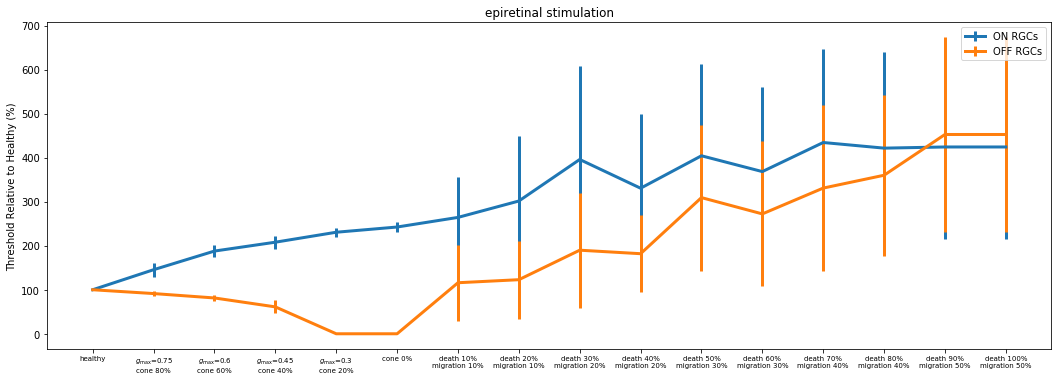

In [10]:
fig, ax = plt.subplots(1,1,figsize=(18, 6))
ax.errorbar(np.arange(16), thres_mean_on, yerr=thres_std_on, label="ON RGCs", linewidth=3)
ax.errorbar(np.arange(16), thres_mean_off, yerr=thres_std_off, label="OFF RGCs", linewidth=3)
ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
ax.set_xticklabels(["healthy", "$g_\max$=0.75\ncone 80%", "$g_\max$=0.6\ncone 60%", "$g_\max$=0.45\ncone 40%", "$g_\max$=0.3\ncone 20%", "cone 0%", "death 10%\nmigration 10%", "death 20%\nmigration 10%", "death 30%\nmigration 20%", "death 40%\nmigration 20%", "death 50%\nmigration 30%", "death 60%\nmigration 30%", "death 70%\nmigration 40%", "death 80%\nmigration 40%", "death 90%\nmigration 50%", "death 100%\nmigration 50%"], fontsize=7)
ax.set_ylabel("Threshold Relative to Healthy (%)")
ax.set_title("epiretinal stimulation")
ax.legend()